In [45]:
import matplotlib.pyplot as plt
import numpy

import iris
import iris.quickplot as qplt

%matplotlib inline

## Initial look at the data

Since the drift removal was done on monthly data, I need to make sure remove it from monthly data before applying a smoothing window (because that window shortens the time axis, which messes up the branch time).

In [46]:
def get_data(experiments):
    """Get the annual timescale data"""
    
    data_dict = {}
    for experiment in experiments:
    
        assert experiment in ['piControl', 'historical']
 
        directory = '/g/data/r87/dbi599/drstree/CMIP5/GCM/CSIRO-BOM/ACCESS1-0/%s/mon/ocean/ohc-metrics/r1i1p1/'  %(experiment)
        #directory = '/Users/damienirving/Downloads/Data/'
        if experiment == 'historical':
            fname = directory+'ohc-metrics_Omon_ACCESS1-0_%s_r1i1p1_all_drift.nc' %(experiment)
        elif experiment == 'piControl':
            fname = directory+'ohc-metrics_Omon_ACCESS1-0_%s_r1i1p1_all.nc' %(experiment)
    
        data_dict[(experiment, 'globe')] = iris.load_cube(fname, 'ocean heat content globe')
        data_dict[(experiment, 'sthext')] = iris.load_cube(fname, 'ocean heat content southern extratropics')
        data_dict[(experiment, 'notsthext')] = iris.load_cube(fname, 'ocean heat content outside southern extratropics')
        
        #data_dict[(experiment, 'globe')] = cube_globe.rolling_window('time', iris.analysis.MEAN, 12)
        #data_dict[(experiment, 'sthext')] = cube_sthext.rolling_window('time', iris.analysis.MEAN, 12)
        #data_dict[(experiment, 'notsthext')] = cube_notsthext = cube_notsthext.rolling_window('time', iris.analysis.MEAN, 12)
    
    return data_dict

In [47]:
experiments = ['piControl', 'historical']
cube_dict = get_data(experiments)

In [48]:
cube_dict.keys()

[('piControl', 'sthext'),
 ('piControl', 'globe'),
 ('historical', 'notsthext'),
 ('historical', 'sthext'),
 ('piControl', 'notsthext'),
 ('historical', 'globe')]

In [49]:
print cube_dict[('historical', 'globe')]

ocean heat content globe / (10^22 J) (time: 1872)
     Dimension coordinates:
          time                            x
     Attributes:
          Conventions: CF-1.5
          associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_ocean_fx_ACCESS1-0_historical_r0i0p0.nc...
          branch_time: 109207.0
          cmor_version: 2.8.0
          contact: The ACCESS wiki: http://wiki.csiro.au/confluence/display/ACCESS/Home. Contact...
          depth_bounds: ohc integrated over full depth of input data (5.000000 down to 5831.29...
          experiment: historical
          experiment_id: historical
          forcing: GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2, N2O, CH4, CFC11, CFC12, CFC113,...
          frequency: mon
          history: Wed May 18 16:25:24 2016: /g/data/r87/dbi599/miniconda2/envs/default/bin/python...
          initialization_method: 1
          institute_id: CSIRO-BOM
          institution: CSIRO (Commonwealth Scientific and Indu

In [50]:
def plot_timeseries(globe_cube, sthext_cube, notsthext_cube, experiment):
    """Blah."""

    qplt.plot(globe_cube.coord('time'), globe_cube, label='global')
    qplt.plot(sthext_cube.coord('time'), sthext_cube, label='southern extratropics')
    qplt.plot(notsthext_cube.coord('time'), notsthext_cube, label='not southern extratropics')

    plt.legend(loc='best')
    plt.title('Ocean heat content, ACCESS1-0, %s' %(experiment))
    plt.ylabel('Ocean heat content (%s)' %(globe_cube.units))

    qplt.show()

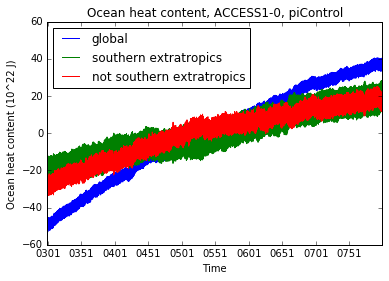

In [51]:
exp = 'piControl'
plot_timeseries(cube_dict[(exp, 'globe')], cube_dict[(exp, 'sthext')], 
                cube_dict[(exp, 'notsthext')], exp)

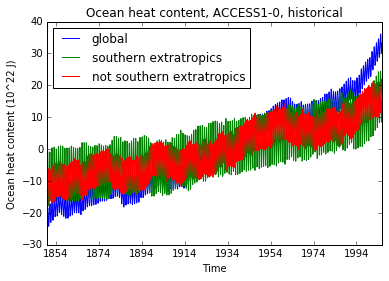

In [52]:
exp = 'historical'
plot_timeseries(cube_dict[(exp, 'globe')], cube_dict[(exp, 'sthext')], 
                cube_dict[(exp, 'notsthext')], exp)

## Check drift

#### Plot comparison

In [53]:
drift_coefficient_file = '/g/data/r87/dbi599/drstree/CMIP5/GCM/CSIRO-BOM/ACCESS1-0/piControl/mon/ocean/ohc-metrics/r1i1p1/ohc-metrics-coefficients_Omon_ACCESS1-0_piControl_r1i1p1_all.nc'
coef_cube = iris.load_cube(drift_coefficient_file, 'ocean heat content globe')

In [54]:
print coef_cube.data

[ -1.43945839e+02   1.10021700e-03  -2.32774676e-09   2.40390287e-15]


In [55]:
def apply_polynomial(x_data, coefficient_data):
    """Evaluate cubic polynomial.
    Args:
      x_data (numpy.ndarray): One dimensional x-axis data
      coefficient_data (numpy.ndarray): Multi-dimensional coefficient array (e.g. lat, lon, depth)
      anomaly (bool): 
        True: provide entire polynomial
        False: provide only the temporal deviations from the initial value (a_data)
    """
    
    coefficient_dict = {}
    if coefficient_data.ndim == 1:
        coefficient_dict['a'] = coefficient_data[0]    
        coefficient_dict['b'] = coefficient_data[1]
        coefficient_dict['c'] = coefficient_data[2]    
        coefficient_dict['d'] = coefficient_data[3]  
    else:
        while x_data.ndim < coefficient_data.ndim:
            x_data = x_data[..., numpy.newaxis]
        for index, coefficient in enumerate(['a', 'b', 'c', 'd']):
            coef = coefficient_data[index, ...]
            coef = numpy.repeat(coef[numpy.newaxis, ...], x_data.shape[0], axis=0)
            assert x_data.ndim == coef.ndim
            coefficient_dict[coefficient] = coef

    result = coefficient_dict['a'] + coefficient_dict['b'] * x_data + coefficient_dict['c'] * x_data**2 + coefficient_dict['d'] * x_data**3  
    
    return result 

In [56]:
control_cube = cube_dict[('piControl', 'globe')]
time_coord = control_cube.coord('time')
drift_signal = apply_polynomial(time_coord.points, coef_cube.data)

drift_signal = iris.cube.Cube(drift_signal,
                              standard_name=control_cube.standard_name,
                              long_name=control_cube.long_name,
                              var_name=control_cube.var_name,
                              units=control_cube.units,
                              attributes=control_cube.attributes,
                              dim_coords_and_dims=[(time_coord, 0)],
                              )

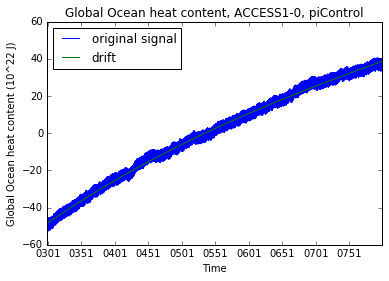

In [58]:
qplt.plot(time_coord, control_cube, label='original signal')
qplt.plot(time_coord, drift_signal, label='drift')

#qplt.plot(time_coord, cube - drift_signal, label='')

plt.legend(loc='best')
plt.title('Global Ocean heat content, ACCESS1-0, piControl')
plt.ylabel('Global Ocean heat content (%s)' %(cube.units))

qplt.show()

#### Remove drift

In [59]:
historical_cube = cube_dict[('historical', 'globe')]

print historical_cube.attributes['branch_time']

print historical_cube.coord('time').units
print historical_cube.coord('time').points

print control_cube.coord('time').units
print control_cube.coord('time').points

print len( control_cube.coord('time').points)

109207.0
days since 0001-01-01
[ 675348.5  675378.   675407.5 ...,  732234.5  732265.   732295.5]
days since 0001-01-01
[ 109222.5  109252.   109281.5 ...,  291751.5  291782.   291812.5]
6000


In [60]:
diff = historical_cube.coord('time').points[0] - historical_cube.attributes['branch_time']
polynomial_times = historical_cube.coord('time').points - diff

print polynomial_times

[ 109207.   109236.5  109266.  ...,  166093.   166123.5  166154. ]


In [61]:
drift_signal = apply_polynomial(polynomial_times, coef_cube.data)
historical_cube_dedrifted = historical_cube - drift_signal

In [62]:
print historical_cube_dedrifted

unknown / (10^22 J)                 (time: 1872)
     Dimension coordinates:
          time                           x


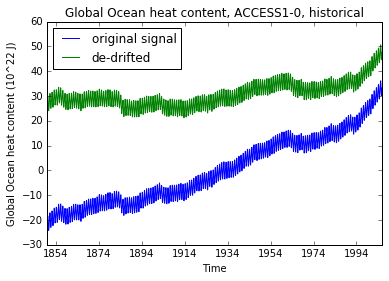

In [64]:
qplt.plot(historical_cube.coord('time'), historical_cube, label='original signal')
qplt.plot(historical_cube_dedrifted.coord('time'), historical_cube_dedrifted, label='de-drifted')

plt.legend(loc='best')
plt.title('Global Ocean heat content, ACCESS1-0, historical')
plt.ylabel('Global Ocean heat content (%s)' %(cube.units))

qplt.show()

## Trends

In [35]:
def plot_difference(diff_cube, experiment):
    """Blah."""

    qplt.plot(diff_cube.coord('time'), diff_cube)

    plt.legend(loc='best')
    plt.title('SthExt - notSthExt, ACCESS1-0, %s' %(experiment))
    plt.ylabel('difference')

    qplt.show()

In [36]:
diff_control = cube_dict[('piControl', 'sthext')] - cube_dict[('piControl', 'notsthext')]
diff_historical = cube_dict[('historical', 'sthext')] - cube_dict[('historical', 'notsthext')]

/Users/damienirving/anaconda/envs/default/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


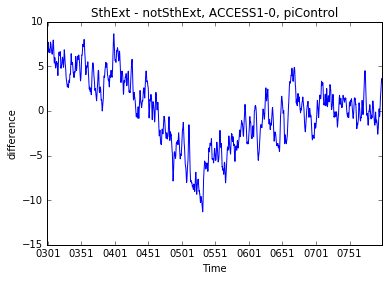

In [37]:
plot_difference(diff_control, 'piControl')

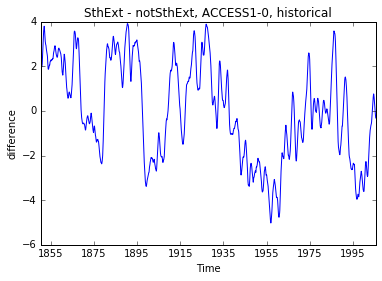

In [39]:
plot_difference(diff_historical, 'historical')

## Trends

Now that I've got the dummy difference data, I need to take the linear trend in 12 year windows. I'm following the example of how to make an aggregator in Iris found [here](http://scitools.org.uk/iris/docs/latest/examples/General/custom_aggregation.html#general-custom-aggregation).

In [13]:
from iris.util import rolling_window
from iris.analysis import Aggregator
from scipy import stats
import numpy

In [14]:
print diff

unknown / (10^22 J m-2)             (time: 1861)
     Dimension coordinates:
          time                           x


In [27]:
windowed_ratio = rolling_window(diff.data, window=12, axis=0)

In [28]:
print windowed_ratio.shape

(1850, 12)


In [29]:
def calc_slope(y, x):
    """ """
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    
    return slope


def linear_trend(data, axis, window_size):
    """ """

    window_array = rolling_window(data, window=window_size, axis=axis)

    x_axis = numpy.arange(0, window_size)    
    trend = numpy.apply_along_axis(calc_slope, -1, window_array, x_axis)
    
    return trend
    

In [30]:
diff_trends = linear_trend(diff.data, 0, 12)

In [31]:
diff_trends.shape

(1850,)

In [32]:
diff_trends[0]

0.043823062123118581

In [33]:
stats.linregress(numpy.arange(0, 12), diff.data[0:12])

LinregressResult(slope=0.043823062123118581, intercept=2.0038454899421105, rvalue=0.58293719465982574, pvalue=0.046668550794181092, stderr=0.019315836734173069)

In [34]:
trend_cube = iris.cube.Cube(diff_trends, dim_coords_and_dims=[(diff.coord('time')[5:-6], 0)])

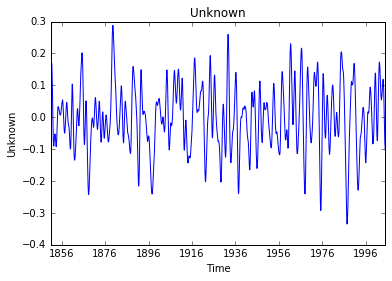

In [35]:
#qplt.plot(diff.coord('time'), diff, label='difference')
qplt.plot(trend_cube.coord('time'), trend_cube, label='trend')

#plt.legend(loc='best')
#plt.title('SthExt / notSthExt, ACCESS1-0, historical')
#plt.ylabel('ratio')

qplt.show()

In [36]:
import seaborn

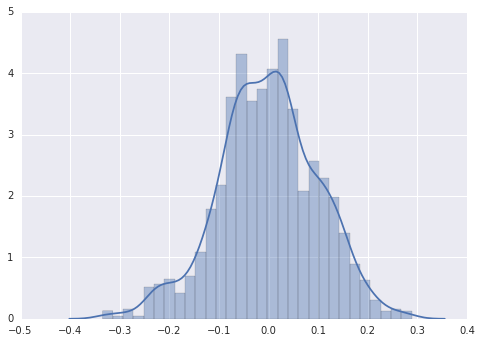

In [38]:
seaborn.distplot(trend_cube.data)